### 데이터 불러오기

In [1]:
!pip install catboost
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 8.7 MB/s eta 0:00:00


In [2]:
### 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

### 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get install -qq fonts-nanum
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
### 데이터
%cd '/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트'
train = pd.read_csv('./review_train.csv', encoding='utf-8')
test = pd.read_csv('./review_test.csv', encoding='utf-8')
print(train.shape, test.shape)

/content/drive/MyDrive/[2024-1] EURON 6기/프로젝트
(2026, 2) (400, 2)


In [4]:
### label encoding
from sklearn.preprocessing import LabelEncoder
n = train.shape[0]
y = pd.concat([train,test])

le = LabelEncoder()
y['keyword2'] = le.fit_transform(y['keyword2'])
train = y[:n]
test = y[n:]

### NLP

In [5]:
### okt
from konlpy.tag import Okt
okt = Okt()
train['okt'] = train['reviews'].apply(okt.morphs)
test['okt'] = test['reviews'].apply(okt.morphs)

In [6]:
### 불용어 제거
with open('./new_stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.readlines()
stop_words = [word.strip() for word in stop_words]


def remove_stopwords(review):
    return [word for word in review if word not in stop_words]


train['okt'] = [remove_stopwords(review) for review in train['okt']]
test['okt'] = [remove_stopwords(review) for review in test['okt']]

In [7]:
### TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_okt = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2,
                            max_df=0.95, stop_words=stop_words)
tfidf_okt_matrix = tfidf_okt.fit_transform(train['reviews'])
tfidf_okt_matrix_test = tfidf_okt.transform(test['reviews'])

In [8]:
### X/y split
X_train = tfidf_okt_matrix
y_train = train['keyword2']
X_test = tfidf_okt_matrix_test
y_test = test['keyword2']

### train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=2024
)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(1620, 92075) (406, 92075) (400, 92075)
(1620,) (406,) (400,)


### DecisionTreeClassifier

[DTC] Validation Accuracy = 0.6626
[DTC] Validation F1 Score = 0.6564
[DTC] Test Accuracy = 0.2025
[DTC] Test F1 Score = 0.21


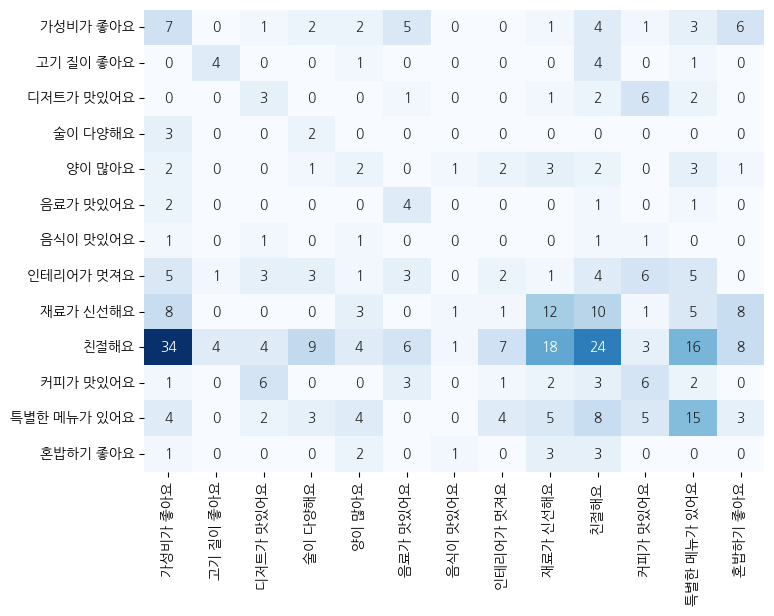

In [ ]:
dt = DecisionTreeClassifier(random_state=2024)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)

valid_acc = accuracy_score(y_valid, dt_pred)
valid_f1 = f1_score(y_valid, dt_pred, average='weighted')
print(f'[DTC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[DTC] Validation F1 Score = {round(valid_f1,4)}')

dt_test_pred = dt.predict(X_test)
test_acc = accuracy_score(y_test, dt_test_pred)
test_f1 = f1_score(y_test, dt_test_pred, average='weighted')
print(f'[DTC] Test Accuracy = {round(test_acc,4)}')
print(f'[DTC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, dt_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### RandomForestClassifier

[RFC] Validation Accuracy = 0.8399
[RFC] Validation F1 Score = 0.8288
[RFC] Test Accuracy = 0.295
[RFC] Test F1 Score = 0.2792


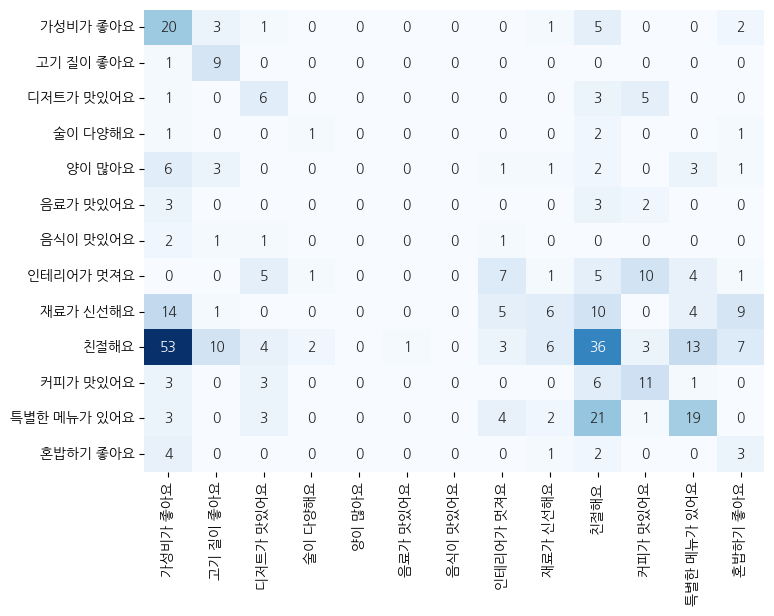

In [ ]:
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)

valid_acc = accuracy_score(y_valid, rf_pred)
valid_f1 = f1_score(y_valid, rf_pred, average='weighted')
print(f'[RFC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[RFC] Validation F1 Score = {round(valid_f1,4)}')

rf_test_pred = rf.predict(X_test)
test_acc = accuracy_score(y_test, rf_test_pred)
test_f1 = f1_score(y_test, rf_test_pred, average='weighted')
print(f'[RFC] Test Accuracy = {round(test_acc,4)}')
print(f'[RFC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, rf_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### SVM

[SVC] Validation Accuracy = 0.8892
[SVC] Validation F1 Score = 0.8898
[SVC] Test Accuracy = 0.345
[SVC] Test F1 Score = 0.3176


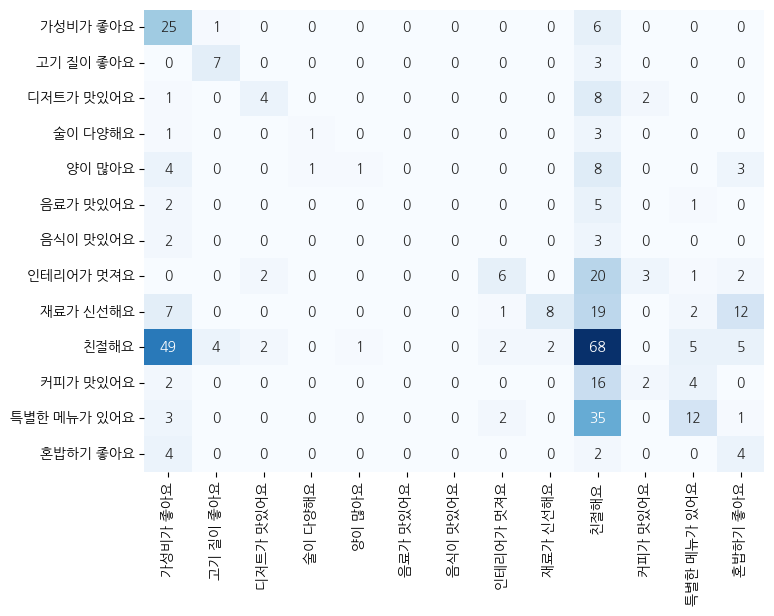

In [ ]:
svm = SVC(random_state=2024)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_valid)

valid_acc = accuracy_score(y_valid, svm_pred)
valid_f1 = f1_score(y_valid, svm_pred, average='weighted')
print(f'[SVC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[SVC] Validation F1 Score = {round(valid_f1,4)}')

svm_test_pred = svm.predict(X_test)
test_acc = accuracy_score(y_test, svm_test_pred)
test_f1 = f1_score(y_test, svm_test_pred, average='weighted')
print(f'[SVC] Test Accuracy = {round(test_acc,4)}')
print(f'[SVC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, svm_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### GradientBoostingClassifier

[GBC] Validation Accuracy = 0.7833
[GBC] Validation F1 Score = 0.776
[GBC] Test Accuracy = 0.2875
[GBC] Test F1 Score = 0.29


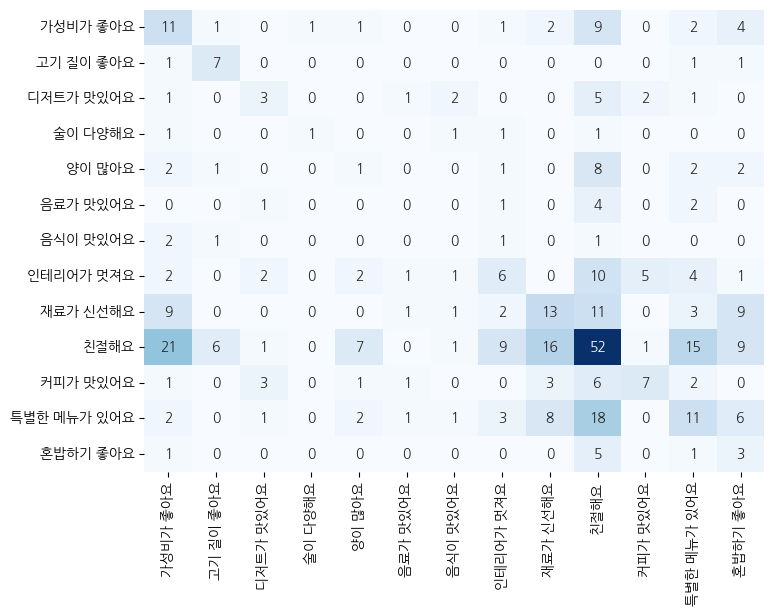

In [ ]:
gbc = GradientBoostingClassifier(random_state=2024)
gbc.fit(X_train, y_train)
gbc_pred = gbc.predict(X_valid)

valid_acc = accuracy_score(y_valid, gbc_pred)
valid_f1 = f1_score(y_valid, gbc_pred, average='weighted')
print(f'[GBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[GBC] Validation F1 Score = {round(valid_f1,4)}')

gbc_test_pred = gbc.predict(X_test)
test_acc = accuracy_score(y_test, gbc_test_pred)
test_f1 = f1_score(y_test, gbc_test_pred, average='weighted')
print(f'[GBC] Test Accuracy = {round(test_acc,4)}')
print(f'[GBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, gbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### XGBClassifier

[XGBC] Validation Accuracy = 0.8251
[XGBC] Validation F1 Score = 0.8156
[XGBC] Test Accuracy = 0.3375
[XGBC] Test F1 Score = 0.3386


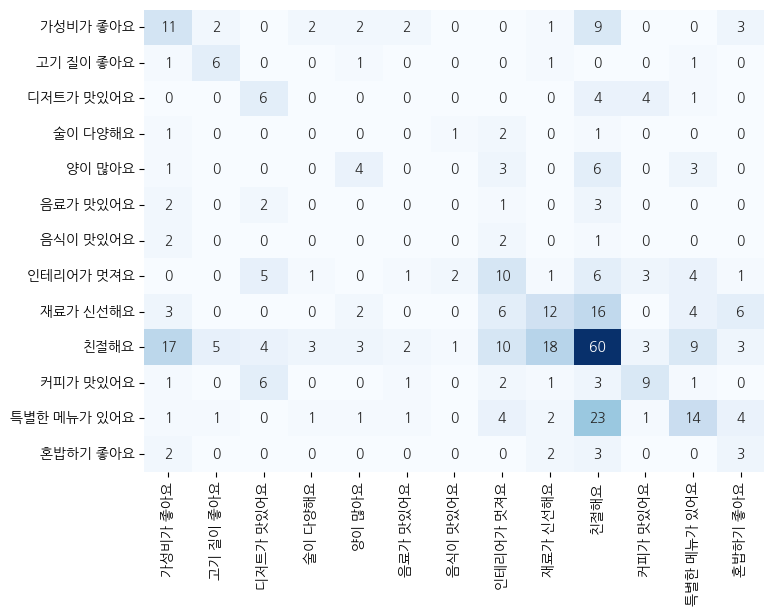

In [ ]:
xgbc = XGBClassifier(random_state=2024)
xgbc.fit(X_train, y_train)
xgbc_pred = xgbc.predict(X_valid)

valid_acc = accuracy_score(y_valid, xgbc_pred)
valid_f1 = f1_score(y_valid, xgbc_pred, average='weighted')
print(f'[XGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[XGBC] Validation F1 Score = {round(valid_f1,4)}')

xgbc_test_pred = xgbc.predict(X_test)
test_acc = accuracy_score(y_test, xgbc_test_pred)
test_f1 = f1_score(y_test, xgbc_test_pred, average='weighted')
print(f'[XGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[XGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, xgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### LGBMClassifier

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105235
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 3785
[LightGBM] [Info] Start training from score -2.359744
[LightGBM] [Info] Start training from score -2.406575
[LightGBM] [Info] Start training from score -2.420368
[LightGBM] [Info] Start training from score -2.455707
[LightGBM] [Info] Start training from score -2.924273
[LightGBM] [Info] Start training from score -2.586160
[LightGBM] [Info] Start training from score -2.680651
[LightGBM] [Info] Start training from score -2.947530
[LightGBM] [Info] Start training from score -2.726742
[LightGBM] [Info] Start training from score -2.507380
[LightGBM] [Info] Start training from score -2.462928
[LightGBM] [Info] Start training from score -2.492

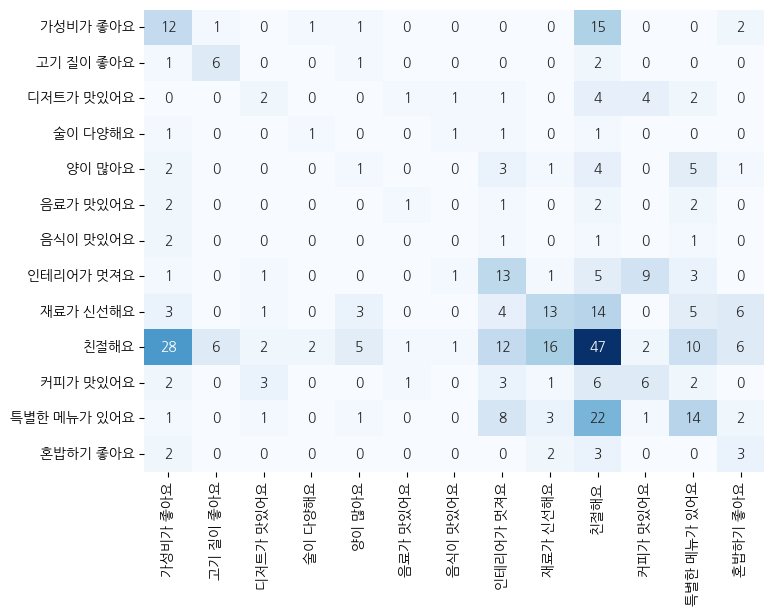

In [ ]:
lgbc = LGBMClassifier(random_state=2024)
lgbc.fit(X_train, y_train)
lgbc_pred = lgbc.predict(X_valid)

valid_acc = accuracy_score(y_valid, lgbc_pred)
valid_f1 = f1_score(y_valid, lgbc_pred, average='weighted')
print(f'[LGBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[LGBC] Validation F1 Score = {round(valid_f1,4)}')

lgbc_test_pred = lgbc.predict(X_test)
test_acc = accuracy_score(y_test, lgbc_test_pred)
test_f1 = f1_score(y_test, lgbc_test_pred, average='weighted')
print(f'[LGBC] Test Accuracy = {round(test_acc,4)}')
print(f'[LGBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, lgbc_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### KNeighborsClassifier

[KNN] Validation Accuracy = 0.6995
[KNN] Validation F1 Score = 0.676
[KNN] Test Accuracy = 0.285
[KNN] Test F1 Score = 0.2795


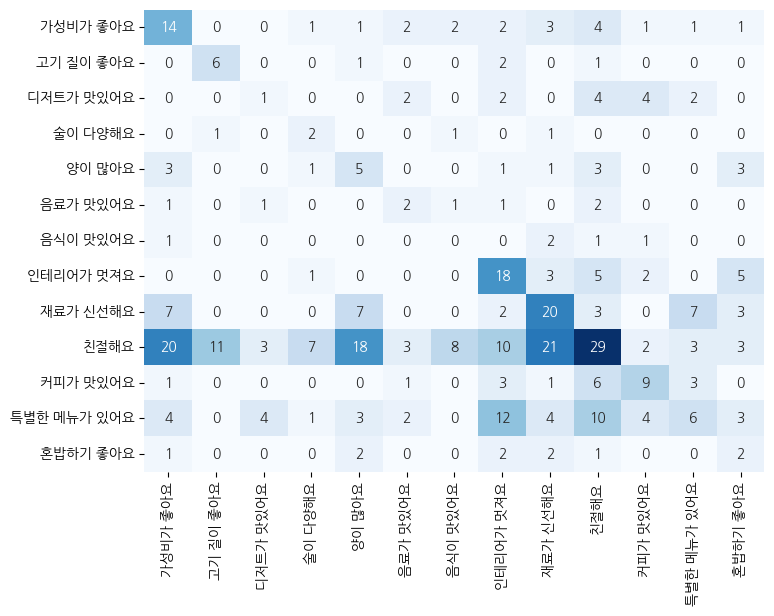

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_valid)

valid_acc = accuracy_score(y_valid, knn_pred)
valid_f1 = f1_score(y_valid, knn_pred, average='weighted')
print(f'[KNN] Validation Accuracy = {round(valid_acc,4)}')
print(f'[KNN] Validation F1 Score = {round(valid_f1,4)}')

knn_test_pred = knn.predict(X_test)
test_acc = accuracy_score(y_test, knn_test_pred)
test_f1 = f1_score(y_test, knn_test_pred, average='weighted')
print(f'[KNN] Test Accuracy = {round(test_acc,4)}')
print(f'[KNN] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, knn_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### GaussianNB

[GNB] Validation Accuracy = 0.931
[GNB] Validation F1 Score = 0.9286
[GNB] Test Accuracy = 0.28
[GNB] Test F1 Score = 0.259


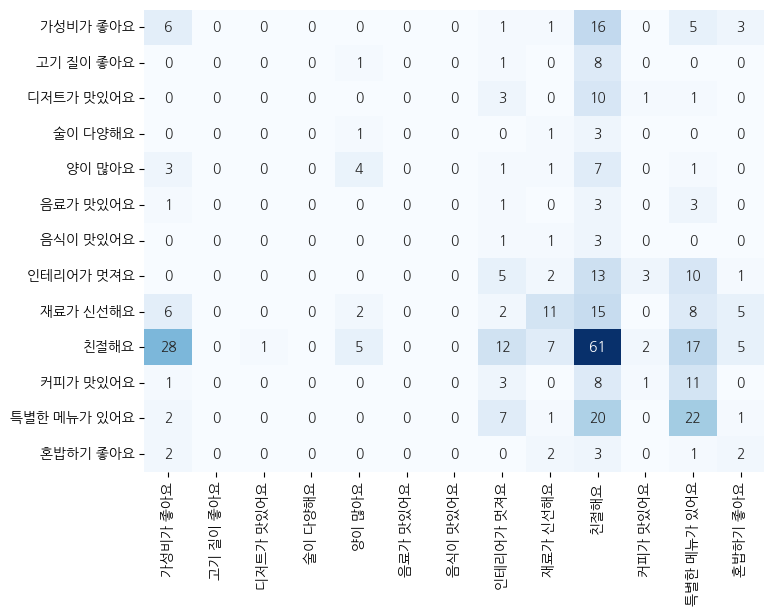

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)
gnb_pred = gnb.predict(X_valid.toarray())

valid_acc = accuracy_score(y_valid, gnb_pred)
valid_f1 = f1_score(y_valid, gnb_pred, average='weighted')
print(f'[GNB] Validation Accuracy = {round(valid_acc,4)}')
print(f'[GNB] Validation F1 Score = {round(valid_f1,4)}')

gnb_test_pred = gnb.predict(X_test.toarray())
test_acc = accuracy_score(y_test, gnb_test_pred)
test_f1 = f1_score(y_test, gnb_test_pred, average='weighted')
print(f'[GNB] Test Accuracy = {round(test_acc,4)}')
print(f'[GNB] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, gnb_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### CatBoostClassifier

Learning rate set to 0.081098
0:	learn: 2.5079576	total: 8.37s	remaining: 2h 19m 24s
1:	learn: 2.4323005	total: 14.5s	remaining: 2h 50s
2:	learn: 2.3665798	total: 22.9s	remaining: 2h 6m 45s
3:	learn: 2.3160257	total: 29s	remaining: 2h 21s
4:	learn: 2.2479051	total: 37.2s	remaining: 2h 3m 17s
5:	learn: 2.2050845	total: 43.2s	remaining: 1h 59m 23s
6:	learn: 2.1632871	total: 51.2s	remaining: 2h 1m 7s
7:	learn: 2.1316331	total: 57.3s	remaining: 1h 58m 28s
8:	learn: 2.0926219	total: 1m 4s	remaining: 1h 58m 51s
9:	learn: 2.0646097	total: 1m 11s	remaining: 1h 58m
10:	learn: 2.0277966	total: 1m 18s	remaining: 1h 57m 21s
11:	learn: 1.9979589	total: 1m 25s	remaining: 1h 57m 56s
12:	learn: 1.9795353	total: 1m 32s	remaining: 1h 56m 40s
13:	learn: 1.9535115	total: 1m 40s	remaining: 1h 57m 53s
14:	learn: 1.9228419	total: 1m 46s	remaining: 1h 56m 32s
15:	learn: 1.9052579	total: 1m 54s	remaining: 1h 57m 51s
16:	learn: 1.8752701	total: 2m 1s	remaining: 1h 56m 45s
17:	learn: 1.8559477	total: 2m 9s	remai

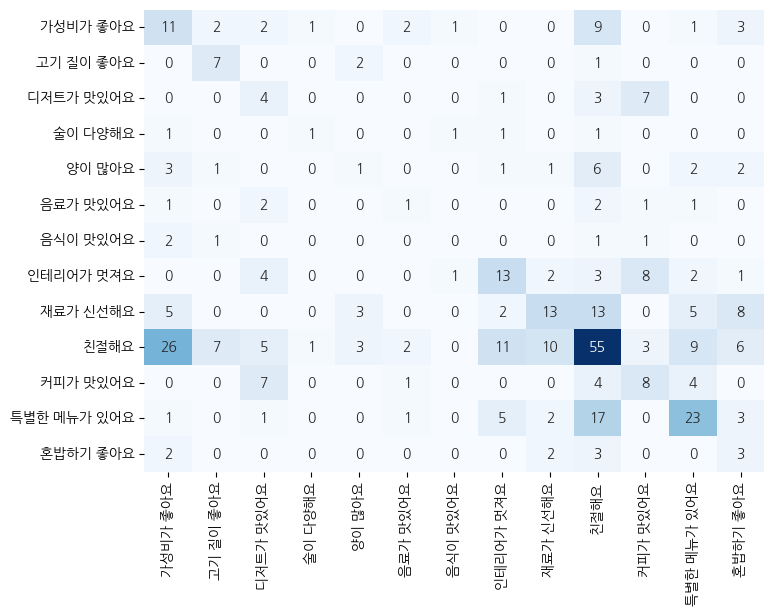

In [ ]:
cb = CatBoostClassifier(random_state=2024)
cb.fit(X_train, y_train)
cb_pred = cb.predict(X_valid)

valid_acc = accuracy_score(y_valid, cb_pred)
valid_f1 = f1_score(y_valid, cb_pred, average='weighted')
print(f'[CBC] Validation Accuracy = {round(valid_acc,4)}')
print(f'[CBC] Validation F1 Score = {round(valid_f1,4)}')

cb_test_pred = cb.predict(X_test)
test_acc = accuracy_score(y_test, cb_test_pred)
test_f1 = f1_score(y_test, cb_test_pred, average='weighted')
print(f'[CBC] Test Accuracy = {round(test_acc,4)}')
print(f'[CBC] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, cb_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()

### Voting

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105235
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 3785
[LightGBM] [Info] Start training from score -2.359744
[LightGBM] [Info] Start training from score -2.406575
[LightGBM] [Info] Start training from score -2.420368
[LightGBM] [Info] Start training from score -2.455707
[LightGBM] [Info] Start training from score -2.924273
[LightGBM] [Info] Start training from score -2.586160
[LightGBM] [Info] Start training from score -2.680651
[LightGBM] [Info] Start training from score -2.947530
[LightGBM] [Info] Start training from score -2.726742
[LightGBM] [Info] Start training from score -2.507380
[LightGBM] [Info] Start training from score -2.462928
[LightGBM] [Info] Start training from score -2.492

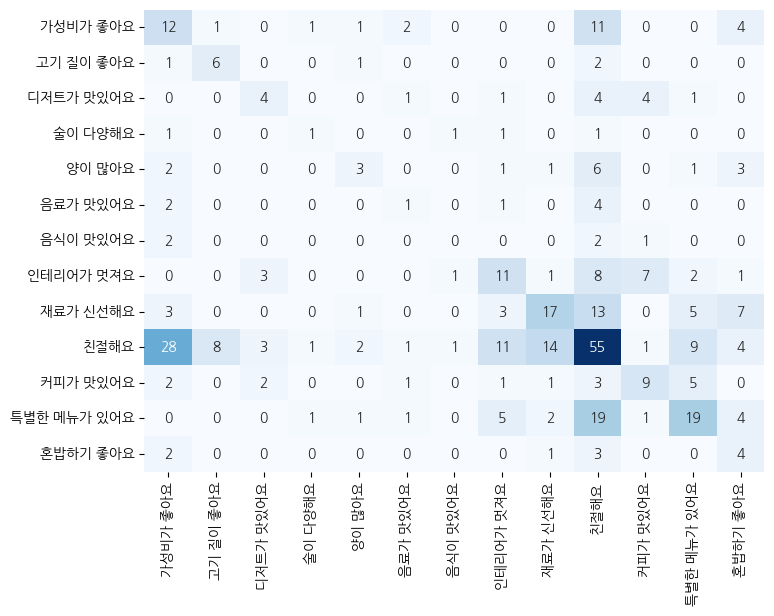

In [9]:
dt = DecisionTreeClassifier(random_state=2024)
rf = RandomForestClassifier(random_state=2024)
svm = SVC(random_state=2024, probability=True)
gbc = GradientBoostingClassifier(random_state=2024)
xgbc = XGBClassifier(random_state=2024)
lgbc = LGBMClassifier(random_state=2024)
knn = KNeighborsClassifier()
gnb = GaussianNB()
cb = CatBoostClassifier(random_state=2024)

voting = VotingClassifier(estimators=[
    ('dt',dt),
    ('rf',rf),
    ('svm',svm),
    ('gbc',gbc),
    ('xgbc',xgbc),
    ('lgbc',lgbc),
    ('knn',knn),
    ('cb',cb)
], voting='soft')

voting.fit(X_train, y_train)
voting_pred = voting.predict(X_valid)

valid_acc = accuracy_score(y_valid, voting_pred)
valid_f1 = f1_score(y_valid, voting_pred, average='weighted')
print(f'[Voting] Validation Accuracy = {round(valid_acc,4)}')
print(f'[Voting] Validation F1 Score = {round(valid_f1,4)}')

voting_test_pred = voting.predict(X_test)
test_acc = accuracy_score(y_test, voting_test_pred)
test_f1 = f1_score(y_test, voting_test_pred, average='weighted')
print(f'[Voting] Test Accuracy = {round(test_acc,4)}')
print(f'[Voting] Test F1 Score = {round(test_f1,4)}')

col = le.classes_
cm = confusion_matrix(y_test, voting_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=col, yticklabels=col)
plt.show()